# **FogML Time Series Data Classification For ISPU**

## FogML installation

In [1]:
!pip install fogml

In [2]:
from sklearn import datasets, tree, naive_bayes
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from fogml.generators import GeneratorFactory

## Data preparation

In the example application for MCU, set `#define DATA_LOGGER` and collect data for various gestures/speeds/etc.

In [3]:
DATA = ["Idle_Data_Log_2024_05_08.csv", "Circle_Data_Log_2024_05_08.csv", "Snake_Data_Log_2024_05_08.csv"]
LABELS = ["IDLE", "CIRCLE", "SNAKE"]

In [4]:
spX_t = []
spY_t = []

i = 0
for fname in DATA:
  tmp = pd.read_csv(fname, delimiter=",", skiprows=1)
  spX_t.append(tmp.iloc[:,15:27])
  spY_t.append([i] * tmp.shape[0])
  i = i + 1

spX = np.concatenate( spX_t, axis = 0 )
spY = np.concatenate( spY_t, axis = 0 )

print(spX)
print(spY)

[[ 1.46400e-02  3.05000e-02  9.02796e-03 ...  0.00000e+00  0.00000e+00
   0.00000e+00]
 [ 3.06952e-01  4.42860e-02  5.64372e-01 ...  4.00000e+00  3.00000e+00
   3.00000e+00]
 [ 7.92024e-01  2.67227e-01  6.93936e-01 ...  2.00000e+00  1.20000e+01
   1.20000e+01]
 ...
 [ 7.44688e-01  3.74540e-02  3.88424e+00 ...  7.00000e+00  9.00000e+00
   9.00000e+00]
 [ 6.88812e-01 -7.85023e-02  4.32929e+00 ...  9.00000e+00  9.00000e+00
   9.00000e+00]
 [ 3.91376e-01  1.08327e-01  3.45260e+00 ...  5.00000e+00  9.00000e+00
   1.00000e+01]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


## PCA Analysis

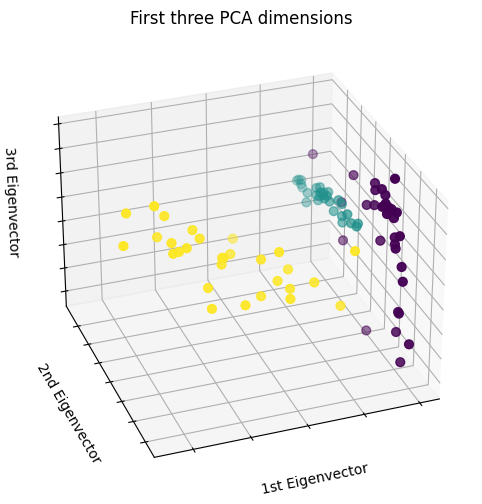

In [5]:
from sklearn.decomposition import PCA

fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

X_reduced = PCA(n_components=3).fit_transform(spX)
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    X_reduced[:, 2],
    c=spY,
    s=40,
)

ax.set_title("First three PCA dimensions")
ax.set_xlabel("1st Eigenvector")
ax.xaxis.set_ticklabels([])
ax.set_ylabel("2nd Eigenvector")
ax.yaxis.set_ticklabels([])
ax.set_zlabel("3rd Eigenvector")
ax.zaxis.set_ticklabels([])

plt.show()

## Random forrest model training

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0.9213483146067416, 0.9550561797752809, 0.9775280898876404, 0.9887640449438202, 1.0, 0.9887640449438202, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


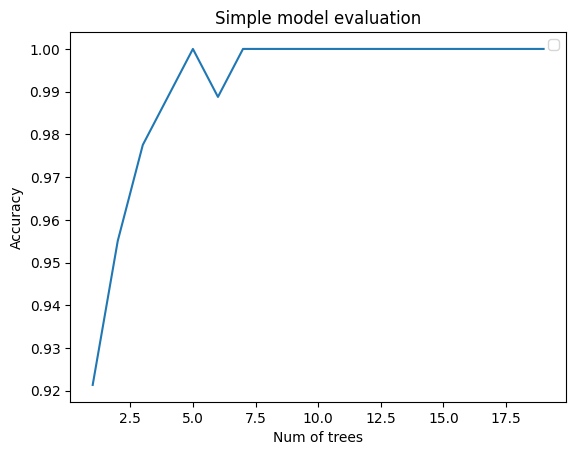

In [24]:
trees_n = [i for i in range(1,20)]
trees_acc = []
trees_clf = []

#training should be improved by using validation set
for i in trees_n:
  clf = RandomForestClassifier(n_estimators = i, max_depth=3, random_state=0)
  clf.fit(spX, spY)
  trees_acc.append(clf.score(spX,spY))
  trees_clf.append(clf)

print(trees_n)
print(trees_acc)

plt.plot(trees_n, trees_acc)
plt.xlabel("Num of trees")
plt.ylabel("Accuracy")
plt.title("Simple model evaluation")
plt.legend()
plt.show()

#pick the model
clf = trees_clf[10]


# FogML Classifier Generation

In [25]:
factory = GeneratorFactory()
generator = factory.get_generator(clf)
generator.generate(fname="classifier.c")

Copy generated `classifier.c` to the folder `generated` in the ISPU project.


# FogML KMeans Anomaly Detector Generation - WiP

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from fogml.anomaly import KMeansAnomalyDetector
from fogml.generators import GeneratorFactory

scaler = MinMaxScaler()
transformer = scaler.fit(spX)
data_norm = transformer.transform(spX)

anomalyDetector = KMeansAnomalyDetector(n_clusters=16)
anomalyDetector.fit(data_norm)

factory = GeneratorFactory()
generator = factory.get_generator(transformer)
generator.generate(fname="min_max_scaler_model.c")

generator = factory.get_generator(anomalyDetector)
generator.generate(fname="kmeans_anomaly_model.c")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Copy generated `kmeans_anomaly_model.c` and `min_max_scaler_model.c` to the folder `fogml_generated` in the MCU project.

## Appendix - Feature Importance Analysis

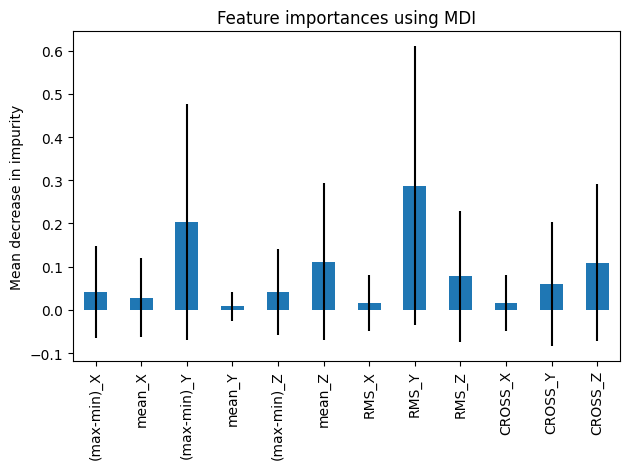

In [ ]:
DSP_BLOCKS = ["BASE", "RMS", "CROSSINGS"]

DSP_BLOCKS_FEATURES = {"BASE": ["(max-min)_X", "mean_X", "(max-min)_Y", "mean_Y", "(max-min)_Z", "mean_Z"],
              "RMS": ["RMS_X", "RMS_Y", "RMS_Z"],
              "CROSSINGS": ["CROSS_X", "CROSS_Y", "CROSS_Z"]}

feature_names = ["(max-min)_X", "mean_X", "(max-min)_Y", "mean_Y", "(max-min)_Z", "mean_Z",
                 "RMS_X", "RMS_Y", "RMS_Z",
                 "CROSS_X", "CROSS_Y", "CROSS_Z"]


importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()